# Can GDP Predict Quality of Life?

An incredibly complicated and eye-opening study by Rahul Iyengar, Matthew Chen, and Sean Boerhout

## Essential Question: How does a country's GDP relate to the quality of life of its individuals?

By analyzing the relationship between a country's GDP and its population density, infant mortality, literacy rate, and even the relative number of phones people own, we can make predictions about how that country's GDP has affected (or serves as a measure of) the quality of life of its inhabitants. 

## Interesting Topics of Analysis

GDP per capita: `GDP ($ per capita)`

GDP per capita vs population density (`Pop. Density (per sq. mi.)`)
GDP per capita vs infant mortality (`Infant mortality (per 1000 births)`)
GDP per capita vs literacy rate (`Literacy (%)`)
GDP per captia vs relative number of phones (`Phones (per 1000)`)


In [138]:
# Import the necessary packages

import pandas as pd                 # For creating and manipulating the DataFrame
import numpy as np                  # For performing mathematical operations on the DataFrame
import scipy.stats as st            # Statistics package for inference
import matplotlib.pyplot as plt     # Plotting package
import statsmodels.formula.api as smf

In [139]:
# Set the plotting style to that of ggplot
plt.style.use('ggplot')

# Import the data
df = pd.read_csv('~/Documents/School/Stats/dataproject/test1/dataframes/countries-of-the-world.csv')

## Clean The Data

We clean our data by dropping useless columns, removing rows with null data, and converting all the columns to the correct data types (most columns are strings with commas instead of decimal points, for some reason)

We also assign the row indexes to be the names of the countries the data represents and print out the first 5 rows as a preview of the new data. 

In [140]:
dropped_cols = ['Arable (%)', 
                'Other (%)', 
                'Climate', 
                'Agriculture', 
                'Industry', 
                'Service']
df.drop(dropped_cols, inplace=True, axis=1)
df.dropna(inplace=True)

for column in df.columns:
  if isinstance(df.loc[5, column], str) and df.loc[5, column].find(',') > 0:
    df[column] = df[column].replace(',', '.', regex=True)
    df[column] = pd.to_numeric(df[column])

print(df.head())

           Country                               Region  Population   
0     Afghanistan         ASIA (EX. NEAR EAST)             31056997  \
1         Albania   EASTERN EUROPE                          3581655   
2         Algeria   NORTHERN AFRICA                        32930091   
3  American Samoa   OCEANIA                                   57794   
4         Andorra   WESTERN EUROPE                            71201   

   Area (sq. mi.)  Pop. Density (per sq. mi.)  Coastline (coast/area ratio)   
0          647500                        48.0                          0.00  \
1           28748                       124.6                          1.26   
2         2381740                        13.8                          0.04   
3             199                       290.4                         58.29   
4             468                       152.1                          0.00   

  Net migration  Infant mortality (per 1000 births)  GDP ($ per capita)   
0         23,06        

## Analyze the Data

Now let's start looking at the data, starting with population density, and since we haven't looked at the GDP data yet, here's that too:

GDP ($ per capita) count      203.000000
mean      9727.586207
std      10213.014779
min        500.000000
25%       1900.000000
50%       5600.000000
75%      14700.000000
max      55100.000000
Name: GDP ($ per capita), dtype: float64


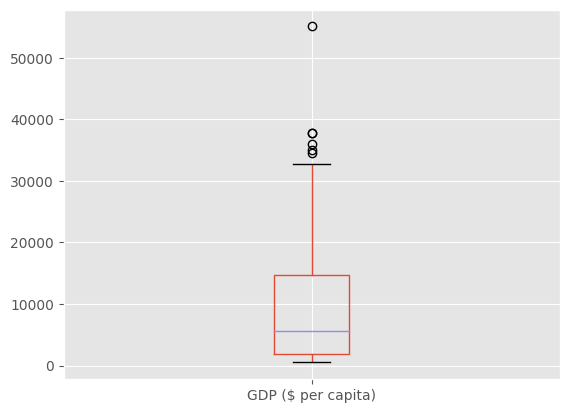

In [141]:
# Prints out a summary of the data and plots a boxplot
def summarize(series):
  print(series, df[series].describe())
  df.boxplot(column=[series])
  plt.show()

# GDP Data:
summarize('GDP ($ per capita)')

### Population Density

Here's a rundown of population density statistics:

Pop. Density (per sq. mi.) count      203.000000
mean       360.892611
std       1716.128660
min          1.800000
25%         27.100000
50%         74.000000
75%        182.850000
max      16271.500000
Name: Pop. Density (per sq. mi.), dtype: float64


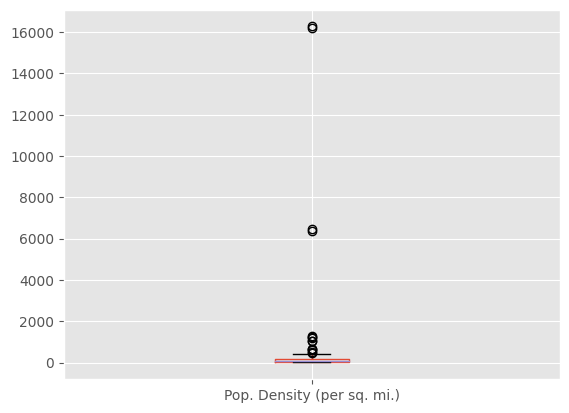

In [142]:
summarize('Pop. Density (per sq. mi.)')

We need a function to do the interpetation of the data for us, since doing that all manually would seem to mock this project:

In [143]:
def interpret_data(series_x, series_y, slope, rvalue, pvalue, stderr, alpha):
  output = 'There is a ' 
  output += ('positive') if slope > 0 else ('negative') 
  output += ', linear, and '
  output += 'moderately strong to strong' if rvalue > 0.6 else 'weak'
  output += f' relationship between {series_x} and {series_y}. \n'
  if pvalue < alpha:
    output += f'Since the p-value is less than {alpha*100}%, reject H0, and there is statistically significant evidence of a linear relationship. \n'
  else:
    output += f'Since the p-value is greater than {alpha*100}%, fail to reject H0, and there is no statistically significant evidence of a linear relationship. \n'
  # Interpret R^2
  output += f'{rvalue**2 * 100}% of the variation in {series_y} is explained by the linear relationship between {series_x} and {series_y}. \n'
  output += f'The linear regression has a standard error of {stderr}.'
  return output

And, of course, a function to plot the data with a regression line that also interprets for us:

In [144]:
def analyze(series_x, series_y, regression_line=True):
  new_df = pd.DataFrame({series_x : df[series_x],
                         series_y : df[series_y]})

  # use numpy to create a regression line
  d = np.polyfit(new_df[series_x], new_df[series_y], 1)
  f = np.poly1d(d)

  slope, intercept, rvalue, pvalue, stderr = st.linregress(new_df[series_x], new_df[series_y])

  # Technically, statsmodels should be able to do everything but I'm too lazy to redo it
  # Renaming is required because statsmodels gets angry at all special characters in the series names - stupid, but ok
  new_df.rename(columns={series_x : 'x', series_y : 'y'}, inplace=True)
  regression_table_model = smf.ols('y ~ x', data=new_df)
  results = regression_table_model.fit()
  new_df.rename(columns={'x' : series_x, 'y' : series_y}, inplace=True)

  new_df.insert(2, 'Treg', f(new_df[series_x]))
  ax = new_df.plot.scatter(x=series_x, y=series_y)
  if regression_line:
    new_df.plot(x=series_x, y='Treg', color='Red', ax=ax)
    plt.legend([series_x, f'{f}'])

  # Plot!
  plt.show()

  print(f"""Regression line for: {series_y} vs {series_x}: {str(f)}; \nR^2: {rvalue**2}; \np-value: {pvalue}""")
  print()
  print(interpret_data(series_x, series_y, slope, rvalue, pvalue, stderr, 0.05))
  print()
  print("Regression table: ")
  print(results.summary())


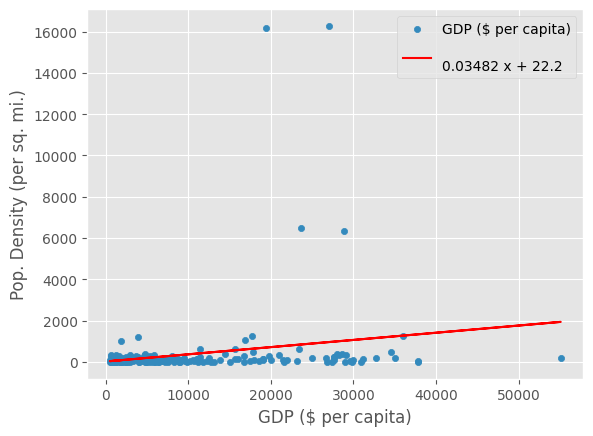

Regression line for: Pop. Density (per sq. mi.) vs GDP ($ per capita):  
0.03482 x + 22.2; 
R^2: 0.042935920515036585; 
p-value: 0.00301389707579805

There is a positive, linear, and weak relationship between GDP ($ per capita) and Pop. Density (per sq. mi.). 
Since the p-value is less than 5.0%, reject H0, and there is statistically significant evidence of a linear relationship. 
4.2935920515036585% of the variation in Pop. Density (per sq. mi.) is explained by the linear relationship between GDP ($ per capita) and Pop. Density (per sq. mi.). 
The linear regression has a standard error of 0.011594936202791188.

Regression table: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     9.017
Date:                Thu, 01 Jun 2023   Prob 

In [145]:
analyze('GDP ($ per capita)', 'Pop. Density (per sq. mi.)', regression_line=True)

### Infant Moratality

Summary:

Infant mortality (per 1000 births) count    203.000000
mean      37.361281
std       36.332153
min        2.290000
25%        8.520000
50%       23.510000
75%       61.655000
max      191.190000
Name: Infant mortality (per 1000 births), dtype: float64


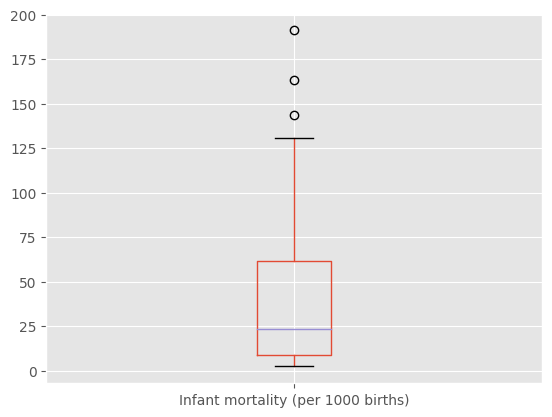

In [146]:
summarize('Infant mortality (per 1000 births)')

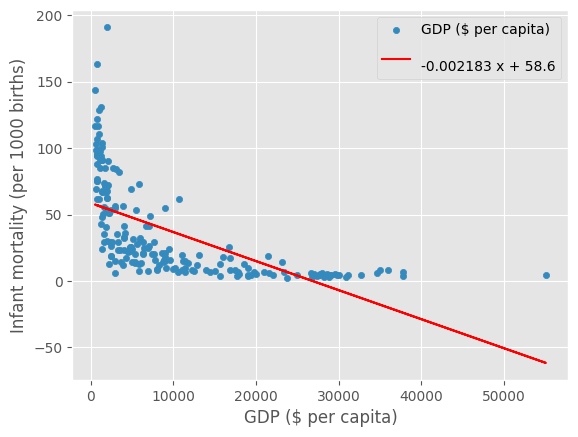

Regression line for: Infant mortality (per 1000 births) vs GDP ($ per capita):  
-0.002183 x + 58.6; 
R^2: 0.37672097891087086; 
p-value: 2.1082067011245008e-22

There is a negative, linear, and weak relationship between GDP ($ per capita) and Infant mortality (per 1000 births). 
Since the p-value is less than 5.0%, reject H0, and there is statistically significant evidence of a linear relationship. 
37.672097891087084% of the variation in Infant mortality (per 1000 births) is explained by the linear relationship between GDP ($ per capita) and Infant mortality (per 1000 births). 
The linear regression has a standard error of 0.0001980981412033179.

Regression table: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     121.5
Date:   

In [147]:
analyze('GDP ($ per capita)', 'Infant mortality (per 1000 births)', regression_line=True)

### Literacy Rate

Summary:

Literacy (%) count    203.000000
mean      82.866995
std       19.721939
min       17.600000
25%       72.400000
50%       92.300000
75%       98.000000
max      100.000000
Name: Literacy (%), dtype: float64


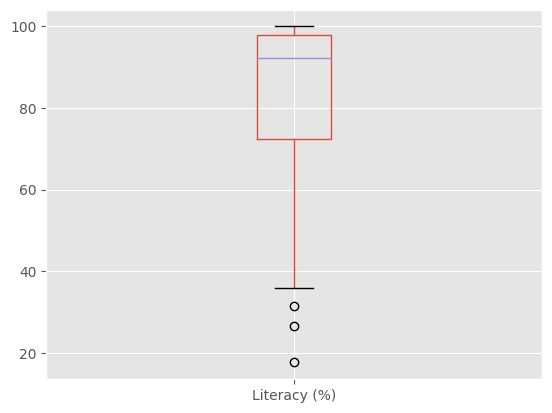

In [148]:
summarize('Literacy (%)')

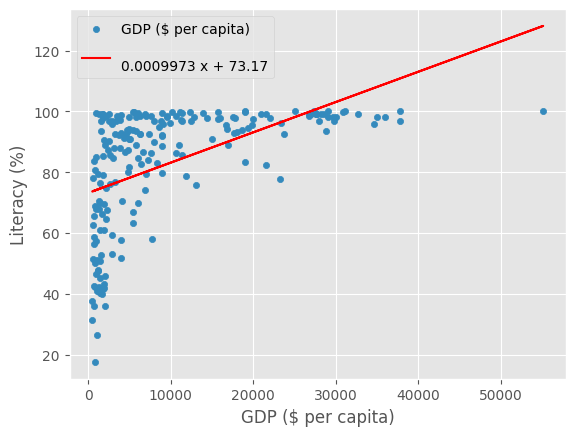

Regression line for: Literacy (%) vs GDP ($ per capita):  
0.0009973 x + 73.17; 
R^2: 0.26671243889875346; 
p-value: 3.0985057653642178e-15

There is a positive, linear, and weak relationship between GDP ($ per capita) and Literacy (%). 
Since the p-value is less than 5.0%, reject H0, and there is statistically significant evidence of a linear relationship. 
26.671243889875345% of the variation in Literacy (%) is explained by the linear relationship between GDP ($ per capita) and Literacy (%). 
The linear regression has a standard error of 0.0001166365837702167.

Regression table: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     73.11
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           3.10e-15
Time:           

In [149]:
analyze('GDP ($ per capita)', 'Literacy (%)', regression_line=True)

### Phones (per 1000)

Summary:

Phones (per 1000) count     203.000000
mean      225.327094
std       219.488969
min         0.200000
25%        32.200000
50%       153.800000
75%       373.100000
max      1035.600000
Name: Phones (per 1000), dtype: float64


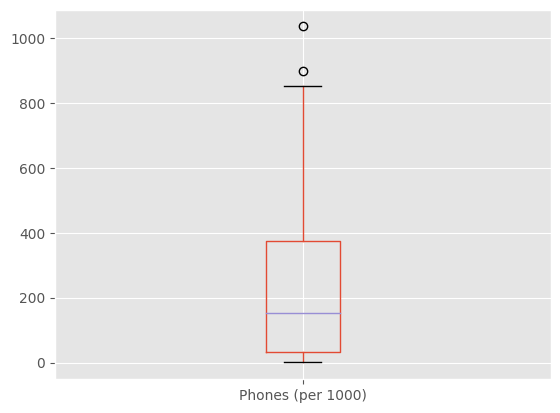

In [150]:
summarize('Phones (per 1000)')

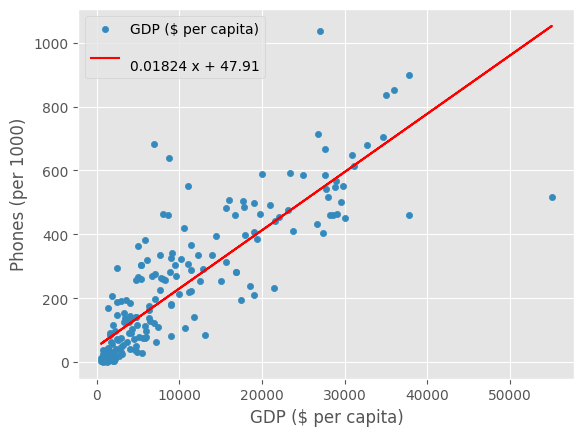

Regression line for: Phones (per 1000) vs GDP ($ per capita):  
0.01824 x + 47.91; 
R^2: 0.7202375761840396; 
p-value: 1.6694359425600815e-57

There is a positive, linear, and moderately strong to strong relationship between GDP ($ per capita) and Phones (per 1000). 
Since the p-value is less than 5.0%, reject H0, and there is statistically significant evidence of a linear relationship. 
72.02375761840396% of the variation in Phones (per 1000) is explained by the linear relationship between GDP ($ per capita) and Phones (per 1000). 
The linear regression has a standard error of 0.0008017803370962011.

Regression table: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     517.5
Date:                Thu, 01 Jun 2023   Prob (F-statisti

In [151]:
analyze('GDP ($ per capita)', 'Phones (per 1000)', regression_line=True)

## Conclusion

For each of the data sets regressed against GDP, there exists strong evidence for a linear association between those variables and GDP. Assuming that these variables serve as an accurate measure of each country's quality of life, it appears that GDP can serve as a fairly good predictor of quality of life - as GDP increases, quality of life increases too. 

The last data set provides very strong evidence of this, and it makes sense; as a measure of economic wellbeing, as GDP increases, it makes sense that the number of consumer devices should increase, and it does with a high degree of predicability (highest R^2 value, of about 72%, of all the data sets).